## **Agriculture - Uganda’s Agricultural Exports**

Data Source: https://www.fao.org/faostat/en/#data/TM

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [2]:
df = pd.read_csv("FAOSTAT_Agric.csv")

In [3]:
df.head()

,Domain Code,Domain,Reporter Country Code (M49),Reporter Countries,Partner Country Code (M49),Partner Countries,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TM,Detailed trade matrix,800,Uganda,12,Algeria,5910,Export quantity,1640,Cocoa beans,2011,2011,t,143.00,A,Official figure
1,TM,Detailed trade matrix,800,Uganda,12,Algeria,5910,Export quantity,1640,Cocoa beans,2013,2013,t,208.00,A,Official figure
2,TM,Detailed trade matrix,800,Uganda,12,Algeria,5910,Export quantity,1640,Cocoa beans,2014,2014,t,275.86,A,Official figure
3,TM,Detailed trade matrix,800,Uganda,12,Algeria,5910,Export quantity,1640,Cocoa beans,2015,2015,t,74.97,A,Official figure
4,TM,Detailed trade matrix,800,Uganda,12,Algeria,5910,Export quantity,1640,Cocoa beans,2017,2017,t,562.15,A,Official figure


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974 entries, 0 to 1973
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Domain Code                  1974 non-null   object 
 1   Domain                       1974 non-null   object 
 2   Reporter Country Code (M49)  1974 non-null   int64  
 3   Reporter Countries           1974 non-null   object 
 4   Partner Country Code (M49)   1974 non-null   int64  
 5   Partner Countries            1974 non-null   object 
 6   Element Code                 1974 non-null   int64  
 7   Element                      1974 non-null   object 
 8   Item Code (CPC)              1974 non-null   int64  
 9   Item                         1974 non-null   object 
 10  Year Code                    1974 non-null   int64  
 11  Year                         1974 non-null   int64  
 12  Unit                         1974 non-null   object 
 13  Value             

In [5]:
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df.dropna(subset=['Value'], inplace=True)

In [6]:
df.isnull().sum()

Domain Code                    0
Domain                         0
Reporter Country Code (M49)    0
Reporter Countries             0
Partner Country Code (M49)     0
Partner Countries              0
Element Code                   0
Element                        0
Item Code (CPC)                0
Item                           0
Year Code                      0
Year                           0
Unit                           0
Value                          0
Flag                           0
Flag Description               0
dtype: int64

In [7]:
df = df[['Year', 'Partner Countries', 'Item', 'Element', 'Value', 'Unit']]

In [8]:
pivot_df = df.pivot_table(index=['Year', 'Partner Countries', 'Item'], columns='Element', values='Value', aggfunc='sum').reset_index()

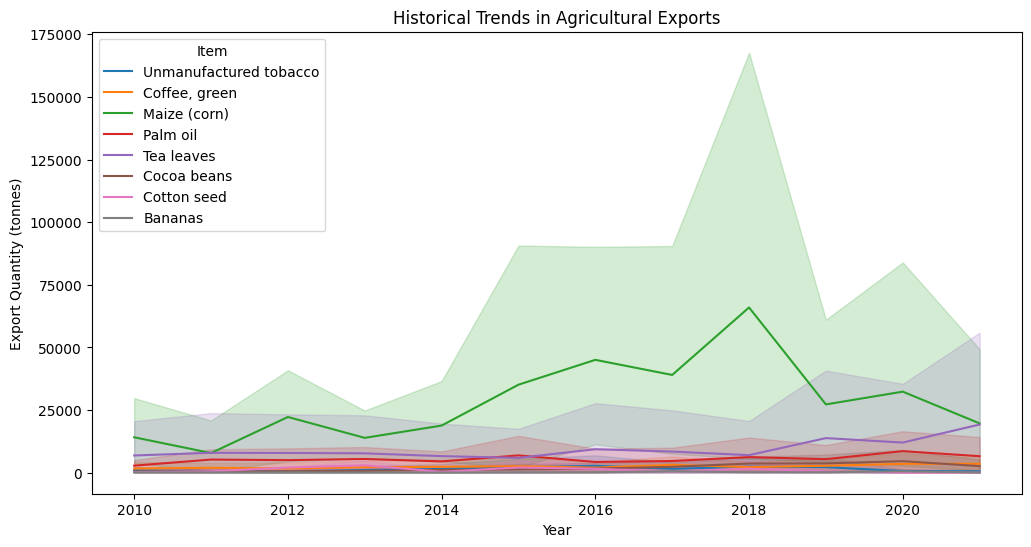

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_df, x='Year', y='Export quantity', hue='Item')
plt.title('Historical Trends in Agricultural Exports')
plt.xlabel('Year')
plt.ylabel('Export Quantity (tonnes)')
plt.show()

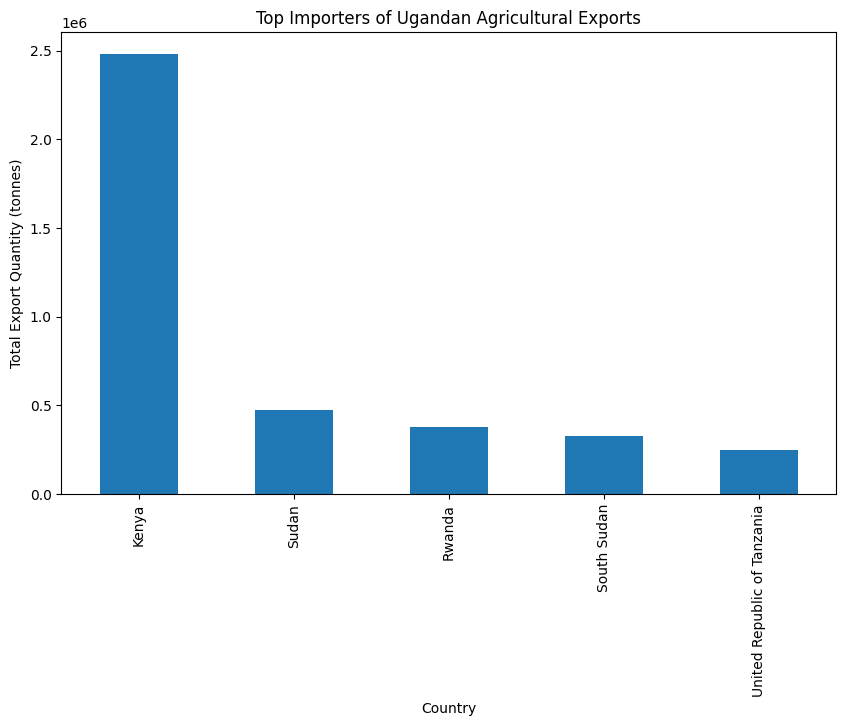

In [10]:
top_countries = pivot_df.groupby('Partner Countries')['Export quantity'].sum().sort_values(ascending=False).head(5)
top_countries.plot(kind='bar', figsize=(10, 6))
plt.title('Top Importers of Ugandan Agricultural Exports')
plt.xlabel('Country')
plt.ylabel('Total Export Quantity (tonnes)')
plt.show()

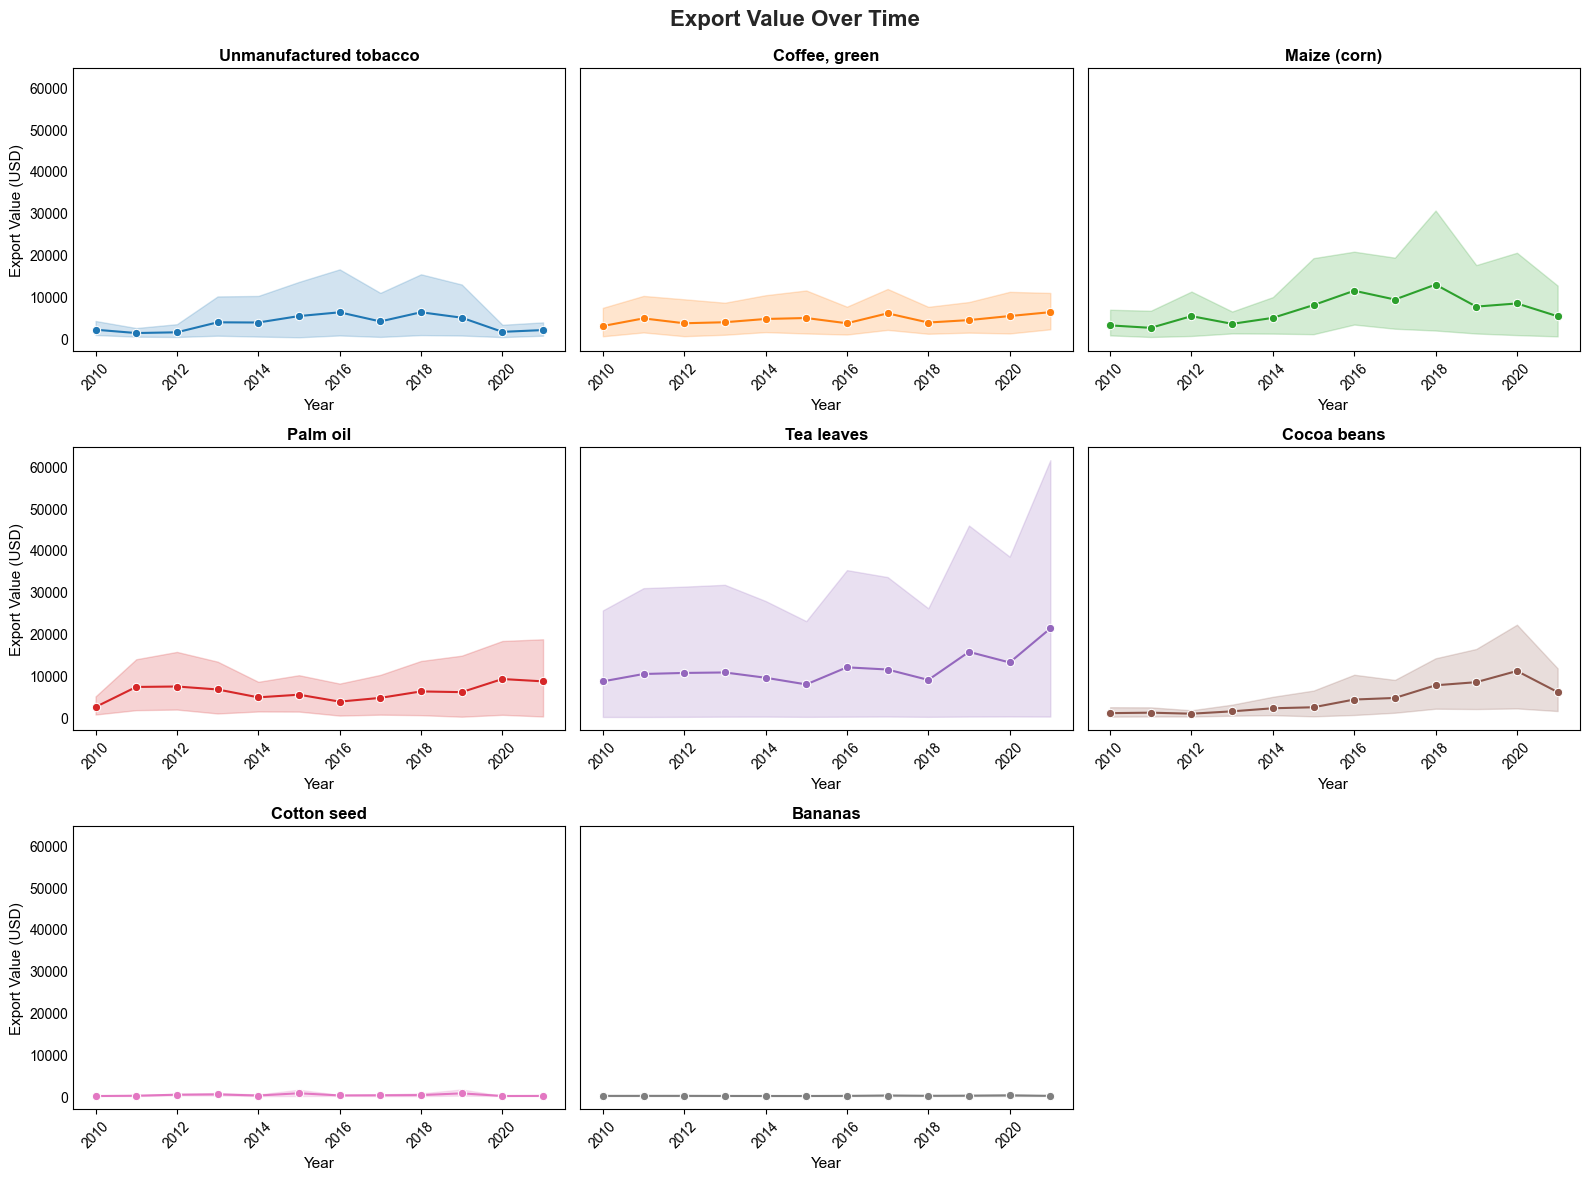

In [11]:
pivot_df['Export value per tonne'] = pivot_df['Export value'] / pivot_df['Export quantity']


unique_items = pivot_df['Item'].unique()


n_items = len(unique_items)
cols = 3 
rows = -(-n_items // cols)  


fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4), sharey=True)
axes = axes.flatten()  


sns.set_style("white")

#
for i, item in enumerate(unique_items):
    ax = axes[i]
    data_subset = pivot_df[pivot_df['Item'] == item]
    
    sns.lineplot(data=data_subset, x='Year', y='Export value', marker="o", color=sns.color_palette("tab10")[i % 10], ax=ax)
    
    ax.set_title(item, fontsize=12, fontweight="bold")
    ax.set_xlabel("Year", fontsize=11)
    ax.set_ylabel("Export Value (USD)", fontsize=11)
   
    ax.yaxis.set_tick_params(length=0)  
    ax.xaxis.set_tick_params(rotation=45)  


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("Export Value Over Time", fontsize=16, fontweight="bold")

plt.show()


Machine Learning Models to predict Export Value

In [12]:
X = pivot_df[['Year', 'Export quantity']]
y = pivot_df['Export value']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.4f}")

Linear Regression RMSE: 9353.0785


In [24]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")

Random Forest RMSE: 6993.3736


In [16]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
arima_model = ARIMA(y_train, order=(5, 1, 0))
arima_model_fit = arima_model.fit()
y_pred_arima = arima_model_fit.forecast(steps=len(y_test))
print(f"ARIMA RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_arima)):.4f}")

ARIMA RMSE: 18551.3902


The Random Forest model is the best among the 3 since it has the smallest mean squared error

### **Dashboard showing Uganda Agricultural Exports**

In [ ]:
top_countries.index = top_countries.index.astype(str)

# Dash App
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Uganda Agricultural Exports Dashboard", style={'textAlign': 'center'}),

    html.Div([
        dcc.Dropdown(
            id='item-dropdown',
            options=[{'label': item, 'value': item} for item in pivot_df['Item'].unique()],
            value='Coffee',
            multi=False,
            style={'width': '50%'}
        ),
        dcc.RangeSlider(
            id='year-slider',
            min=pivot_df['Year'].min(),
            max=pivot_df['Year'].max(),
            step=1,
            marks={int(year): str(year) for year in pivot_df['Year'].unique()},
            value=[pivot_df['Year'].min(), pivot_df['Year'].max()]
        ),
    ], style={'margin': '20px'}),

    html.Div([
        dcc.Graph(id='export-trends', style={'width': '48%', 'display': 'inline-block'}),
        dcc.Graph(id='top-importers', style={'width': '48%', 'display': 'inline-block'}),
    ]),
])

@app.callback(
    Output('export-trends', 'figure'),
    Output('top-importers', 'figure'),
    Input('item-dropdown', 'value'),
    Input('year-slider', 'value')
)
def update_dashboard(selected_item, selected_years):
    # Filter data based on selection
    filtered_df = pivot_df[
        (pivot_df['Item'] == selected_item) &
        (pivot_df['Year'].between(selected_years[0], selected_years[1]))
    ]

    # **Bar Chart for Export Trends**
    fig1 = px.histogram(
    filtered_df,
    x='Year',
    y='Export quantity',
    histfunc='sum',  # Aggregates values by summing
    title=f'Export Trends of {selected_item}',
    labels={'Year': 'Year', 'Export quantity': 'Export Quantity (Tonnes)'}, 
    )

    fig1.update_layout(
    template="plotly_white",
    xaxis_title="Year",
    yaxis_title="Export Quantity (in tonnes)",
    hovermode="x unified",
    showlegend=False
    )

    # **Top 5 Importers**
    top_countries = (
        filtered_df.groupby('Partner Countries')['Export quantity']
        .sum()
        .sort_values(ascending=False)
        .head(5)  # Show only top 5 importers
    )

    
    if top_countries.empty:
        top_countries = pd.Series({'No Data': 0})  

    
    top_countries.index = top_countries.index.astype(str)

    # Bar Chart for Top Importers
    fig2 = px.bar(
        x=top_countries.index,
        y=top_countries.values,
        title='Top 5 Importers',
        labels={'x': 'Country', 'y': 'Export Volume'},
        color=top_countries.index
    )

    return fig1, fig2

if __name__ == '__main__':
    app.run_server(debug=True)